In [1]:
import pandas as pd
import numpy as np
import re
import string

In [5]:
from time import time  # To time our operations
from collections import defaultdict  # For word frequency
from collections import  Counter
import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim


from nltk.corpus import stopwords
from nltk.util import ngrams

from nltk.tokenize import word_tokenize
import gensim
import string
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import nltk
from nltk.stem.snowball import SnowballStemmer


In [7]:
#Cargamos dataset train en un dataframe
tweets_train = pd.read_csv('Dataset/train.csv')
tweets_test = pd.read_csv('Dataset/test.csv')
tweets_submission = pd.read_csv('Dataset/sample_submission.csv') 


In [8]:
tweets_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [9]:
#Dropeamos 'Keyword' y 'Location' ya que no los vamos a utilizar
tweets_train.drop(columns = ['keyword','location'])

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...
7608,10869,Two giant cranes holding a bridge collapse int...,1
7609,10870,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,Police investigating after an e-bike collided ...,1


In [18]:
tweets_train['cleaned_text']=tweets_train['text'].apply(lambda x: re.sub(r'[0-9_]','',x))

In [19]:
tweets_test['cleaned_text']=tweets_test['text'].apply(lambda x: re.sub(r'[0-9_]','',x))

In [10]:
tweets_train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [11]:
tweets_test.head(10)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
5,12,NaN,NaN,We're shaking...It's an earthquake
6,21,NaN,NaN,They'd probably still show more life than Arse...
7,22,NaN,NaN,Hey! How are you?
8,27,NaN,NaN,What a nice hat?
9,29,NaN,NaN,Fuck off!


In [12]:
x = tweets_train.text
y = tweets_train.target


In [13]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [14]:
x_train

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @670TheScore wld b a shame if tha...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
                              ...                        
5226    @Eganator2000 There aren't many Obliteration s...
5390    just had a panic attack bc I don't have enough...
860     Omron HEM-712C Automatic Blood Pressure Monito...
7603    Officials say a quarantine is in place at an A...
7270    I moved to England five years ago today. What ...
Name: text, Length: 6090, dtype: object

In [24]:

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedCountVectorizer(CountVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

count_vect = StemmedCountVectorizer(stop_words='english', lowercase = True)
tweets_train_counts = count_vect.fit_transform(x_train)
tweets_test_counts = count_vect.transform(x_test)
tweets_train_counts.shape


#Bag of Words 
#Vectorizamos los textos de cada tweet
#count_vect = CountVectorizer(stop_words = ('english'), lowercase = True)
#tweets_train_counts = count_vect.fit_transform(x_train)
#tweets_test_counts = count_vect.transform(x_test)
#tweets_train_counts.shape
#print(count_vect.get_feature_names())

(6090, 15764)

In [25]:
#TFIDF
tfidf_transformer = TfidfTransformer()
tweets_train_tfidf = tfidf_transformer.fit_transform(tweets_train_counts)
tweets_test_tfidf = tfidf_transformer.transform(tweets_test_counts)


tweets_train_tfidf.shape

(6090, 15764)

In [17]:

tweets_train_NB = MultinomialNB().fit(tweets_train_tfidf, y_train)
predicted = tweets_train_NB.predict(tweets_test_tfidf)
np.mean(predicted == y_test)

0.8010505581089954

In [36]:
#Prueba4 parametros, maxima iteracion = 10, quedaba en loss modified huber
#Prueba5 es el que da abajo
parameters = {'alpha': ([0.0001, 0.001, 0.05,1])}

gs_NB = GridSearchCV(tweets_train_NB, parameters, n_jobs=-1)
gs_NB = gs_NB.fit(tweets_train_tfidf, y_train)


In [33]:

gs_NB_best = gs_NB.best_estimator_
gs_NB.best_score_
gs_NB.best_params_

{'alpha': 0.5}

In [34]:
best_NB = gs_NB_best.fit(tweets_train_tfidf, y_train)

In [35]:
predicted = best_NB.predict(tweets_test_tfidf)
np.mean(predicted == y_test)

0.7971109652002626

In [62]:
test_text = tweets_test.cleaned_text
test_text_counts = count_vect.transform(test_text)
test_text_tfidf = tfidf_transformer.transform(test_text_counts)
test_target_predicted = best_NB.predict(test_text_tfidf)

In [63]:
tweets_submission.target = test_target_predicted
tweets_submission.to_csv("submission.csv",index=False)

Text(0, 0.5, 'Cantidad de tweets')

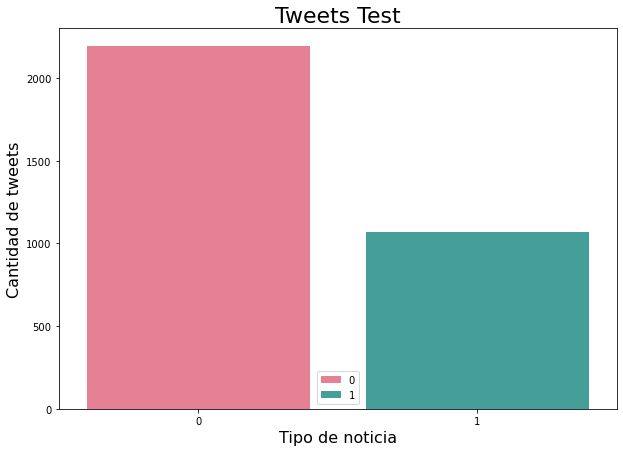

In [64]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
g = sns.barplot(x= tweets_submission.target.value_counts().index, y= tweets_submission.target.value_counts().values, orient='v', palette= 'husl', hue= tweets_submission.target.value_counts().index, dodge=False)
g.set_title("Tweets Test", fontsize=22)
g.set_xlabel("Tipo de noticia", fontsize=16)
g.set_ylabel("Cantidad de tweets", fontsize=16)